In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import os
from torch.utils.data import Dataset
from PIL import Image
import random
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from sklearn.model_selection import KFold
from torch.utils.data.dataset import Subset
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

columns = ["filename", "classname", "gender", "age"]

# BASE = "./data"
BASE = "/content/drive/MyDrive/Colab Notebooks/data/preprocessed"
data_csv_file = os.path.join(BASE, "./data.csv")
data_folder = os.path.join(BASE, "./images")
root_folder = os.path.join(BASE, "./")

data_df = pd.read_csv(data_csv_file, skiprows=1, names=columns)

In [3]:
# get image data
def getImageData(folder, image_file):
    return Image.open(os.path.join(folder, image_file)).convert('RGB') # Load the image

# create directory
def make_dir(dir_path):
    if not os.path.isdir(dir_path):
        os.makedirs(dir_path)

model_path = os.path.join(root_folder, 'model', 'face_mask_detection.pth')
# make_dir(model_path)


In [4]:
# predefined classes
classes = {
    "face_with_cloth_mask": 0,
    "face_no_mask": 1,
    "face_with_ffp2_mask": 2,
    "face_with_surgical_mask": 3
}

genderGroup = {
    '0': 'Female',
    '1': 'Male'
}

ageGroup = {
    '0': '0-30 Age group',
    '1': '30-60 Age Group'
}

def to_gender_str(label):
  return genderGroup[label]

def to_age_str(label):
  return ageGroup[label]

def to_gender_str(label):
  return genderGroup[label]

def to_age_str(label):
  return ageGroup[label]

def to_face_mask_type_str(label):
  for classname in classes.keys():
    if classes[classname] == label:
      return classname
  return 'NULL'

def to_face_mask_type_label(classname):
  return classes[classname]

def to_gender_label(classname):
  for label in genderGroup.keys():
    if genderGroup[label] == classname:
      return label
  return -1

def to_age_label(classname):
  for label in genderGroup.keys():
    if genderGroup[label] == classname:
      return label
  return -1

In [5]:
class FaceMaskDataset(Dataset):
    def __init__(self, indexes, conversion=transforms.ToTensor()):
        self.dataset = []
        self.conversion = conversion
        for rowIndex in indexes:
            sample = {}
            sample['image'] = getImageData(data_folder, data_df[columns[0]][rowIndex])
            sample['target'] = to_face_mask_type_label(data_df[columns[1]][rowIndex])
            sample['gender'] = str(int(data_df[columns[2]][rowIndex]) - 1)
            sample['age'] = str(int(data_df[columns[3]][rowIndex]) - 1)
            self.dataset.append(sample)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        image = self.dataset[index]['image']
        if self.conversion is not None:
            image = self.conversion(image)
        return image, self.dataset[index]['target'], self.dataset[index]['gender'], self.dataset[index]['age']

In [6]:
from sklearn.model_selection import train_test_split

size_of_the_dataset = int(data_df.shape[0])
print("size_of_the_dataset", size_of_the_dataset)

batch_size = 20
num_of_classes = len(classes.keys())

indexes = list(range(size_of_the_dataset))

train_indexes, gtest_indexes = train_test_split(indexes, test_size=0.3, shuffle=True)

print(f"Effective train split = {len(train_indexes)}")
# print(f"Effective val split = {len(val_indexes)}")
print(f"Effective test split = {len(gtest_indexes)}")

print(f"Effective train split = {len(train_indexes)/len(indexes)*100}%")
# print(f"Effective val split = {len(val_indexes)/len(indexes)*100}%")
print(f"Effective test split = {len(gtest_indexes)/len(indexes)*100}%")

size_of_the_dataset 2318
Effective train split = 1622
Effective test split = 696
Effective train split = 69.97411561691112%
Effective test split = 30.02588438308887%


In [7]:
transform = transforms.Compose(
    [transforms.Resize((250, 250)),
        transforms.ToTensor()])

In [8]:
print("Loading training set")
train_dataset = FaceMaskDataset(train_indexes, conversion=transform)

Loading training set


In [9]:
print("Loading test set")

gtest_dataset = FaceMaskDataset(gtest_indexes, conversion=transform)
# gtest_loader = torch.utils.data.DataLoader(dataset=gtest_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

Loading test set


In [10]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [11]:
import torch.nn as nn
import torch.nn.functional as F

class FaceMaskClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels, _, _ = batch 
        images, labels = images.to(device), labels.to(device)
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        scores, predictions = torch.max(out.data, 1)
        train_correct = (predictions == labels).sum().item()
        return loss, train_correct
    
    def validation_step(self, batch):
        images, labels = batch 
        images, labels = images.to(device), labels.to(device)
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, train_accuracy: {:.4f}".format(
            epoch+1, result['train_loss'], result['train_accuracy']))

In [12]:
class CNN(FaceMaskClassificationBase):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.02),

            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.02),

            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.02),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.02),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(6272, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(128, num_of_classes),
        )

    def forward(self, x):
        # conv layers
        x = self.conv_layer(x)
        # flatten
        x = x.view(x.size(0), -1)
        # fc layer
        x = self.fc_layer(x)
        return x


In [13]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, history, opt_func = torch.optim.SGD):
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        model.train()
        train_losses = []
        train_correct = 0
        for batch in train_loader:
            images, labels, _, _ = batch
            # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
            loss, correct = model.training_step(batch)
            # update-training-loss
            train_losses.append(loss)

            train_correct += correct
            # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
            loss.backward()
            # perform-a-single-optimization-step (parameter-update)
            optimizer.step()
            # clear-the-gradients-of-all-optimized-variables
            optimizer.zero_grad()
            
        #result = evaluate(model, val_loader)
        result = {}
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_accuracy'] = train_correct / len(train_loader.dataset) * 100
        
        model.epoch_end(epoch, result)
        #history.append(result)

    history['train_loss'] = result['train_loss']
    history['train_accuracy'] = result['train_accuracy']

    return history

In [14]:
model = CNN()
model = model.to(device)

In [15]:
from sklearn.metrics import precision_recall_fscore_support as score

def test_phase(model, test_loader, history):
  y_true = torch.tensor([])
  y_true = y_true.to(device)
  y_preds = torch.tensor([])
  y_preds = y_preds.to(device)

  # test-the-model
  model.eval()  # it-disables-dropout
  with torch.no_grad():
      correct = 0
      total = 0
      for images, labels, _, _ in test_loader:
          images = images.to(device)
          labels = labels.to(device)
          y_true = torch.cat(
              (y_true, labels)
          )
          outputs = model(images)

          loss = F.cross_entropy(outputs, labels) # Calculate loss
          scores, predicted = torch.max(outputs.data, 1)
          

          #_, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          y_preds = torch.cat(
              (y_preds, predicted)
          )

      test_accuracy = correct / total * 100
      print('Test loss of the model: {:.4f} %'.format(loss)) 
      print('Test Accuracy of the model: {} %'.format(test_accuracy))

      history['test_loss'] = loss
      history['test_accuracy'] = test_accuracy


  y_true = y_true.to('cpu')
  y_preds = y_preds.to('cpu')
  
  precision, recall, fscore, support = score(y_true, y_preds)
  print(classification_report(y_true,y_preds))

  return history

In [16]:
k = 10

def KFold_creator(model, dataset, batch_size, device):
  kfold = KFold(n_splits=k, shuffle=True)
  fold_value = 1;
  foldperf={}
  for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset)):
    print('Fold {}'.format(fold + 1))
    train_data = Subset(dataset, train_idx)
    test_data = Subset(dataset, test_idx)

    train_loader = torch.utils.data.DataLoader(dataset=train_data,batch_size=batch_size,num_workers=0, shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_data,batch_size=batch_size,num_workers=0, shuffle=True)
    
    #model.apply(reset_weights)

    history = {'train_loss': 0, 'test_loss': 0,'train_accuracy': 0,'test_accuracy': 0}

    history = fit(10, 0.0001, model, train_loader, history, torch.optim.Adam)
    history = test_phase(model, test_loader, history)

    foldperf['fold{}'.format(fold+1)] = history   
  
  return foldperf

In [17]:
from sklearn.metrics import confusion_matrix, classification_report

foldperf = KFold_creator(model, train_dataset, batch_size, device)

Fold 1
Epoch [1], train_loss: 1.3123, train_accuracy: 36.6004
Epoch [2], train_loss: 1.1419, train_accuracy: 49.8972
Epoch [3], train_loss: 1.0198, train_accuracy: 57.5051
Epoch [4], train_loss: 0.8963, train_accuracy: 65.0446
Epoch [5], train_loss: 0.7826, train_accuracy: 69.2255
Epoch [6], train_loss: 0.6729, train_accuracy: 74.9143
Epoch [7], train_loss: 0.5529, train_accuracy: 80.1919
Epoch [8], train_loss: 0.4302, train_accuracy: 85.1953
Epoch [9], train_loss: 0.3729, train_accuracy: 87.7313
Epoch [10], train_loss: 0.3038, train_accuracy: 90.0617
Test loss of the model: 0.4529 %
Test Accuracy of the model: 65.03067484662577 %
              precision    recall  f1-score   support

         0.0       0.59      0.47      0.52        34
         1.0       0.62      0.82      0.71        49
         2.0       0.72      0.67      0.69        42
         3.0       0.67      0.58      0.62        38

    accuracy                           0.65       163
   macro avg       0.65      0.63  

In [18]:
testLoss, trainLoss, testAccuracy, trainAccuracy = [], [], [], []
for f in range(1, k+1):
  trainLoss.append(foldperf['fold{}'.format(f)]['train_loss'])
  trainAccuracy.append(foldperf['fold{}'.format(f)]['train_accuracy'])
  testLoss.append(foldperf['fold{}'.format(f)]['test_loss'])
  testAccuracy.append(foldperf['fold{}'.format(f)]['test_accuracy'])

print('Performance of {} fold cross validation'.format(k))
print("Average Training Loss: {:.4f} \t Average Test Loss: {:.4f} \t Average Training Acc: {:.4f} \t Average Test Acc: {:.4f}".format(np.mean(trainLoss),sum(testLoss)/k,np.mean(trainAccuracy),sum(testAccuracy)/k))     

Performance of 10 fold cross validation
Average Training Loss: 0.0581 	 Average Test Loss: 0.2395 	 Average Training Acc: 98.1293 	 Average Test Acc: 94.4702


In [19]:
import matplotlib.pyplot as plt

def plot_accuracies(trainAccuracy, testAccuracy):
    """ Plot the accuracies in each fold"""
    plt.figure(figsize=(10,8))
    plt.semilogy(trainAccuracy, label='Train')
    plt.semilogy(testAccuracy, label='Test')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy vs. No. of folds')
    plt.show()

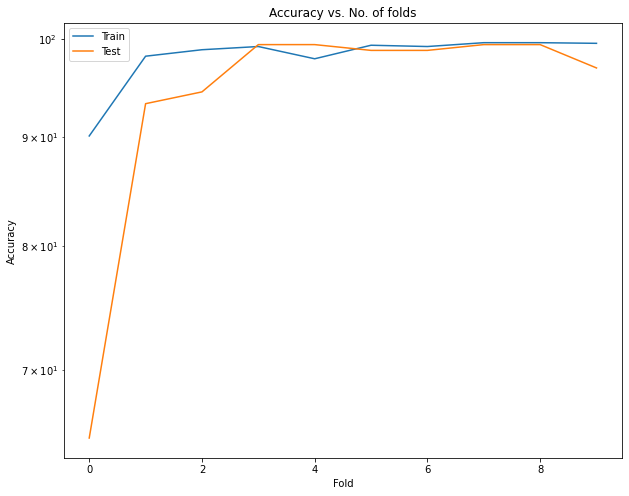

In [20]:
plot_accuracies(trainAccuracy, testAccuracy)


In [21]:
def model_predict(model, dataset):
  y_actuals = []
  y_preds = torch.tensor([])
  y_preds = y_preds.to(device)

  # test-the-model
  model.eval()  # it-disables-dropout
  with torch.no_grad():
      for image, label, _, _ in dataset:
        image = image.unsqueeze(0)
        image = image.to(device)
        outputs = model(image)
        _, predicted = torch.max(outputs.data, 1)
        predicted = predicted.unsqueeze(0)
        y_preds = torch.cat(
            (y_preds, predicted)
        )

        y_actuals.append(label)
  return np.array(y_actuals, dtype=np.float64), torch.reshape(y_preds.to('cpu'), (-1, )).numpy()

In [22]:
y_actuals, y_preds = model_predict(model, gtest_dataset)

In [23]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def heat_map(y_true, y_preds, x_label, y_label, title):
    matrix = confusion_matrix(y_true, y_preds)
    plt.figure(figsize = (10,7))
    ax = sns.heatmap(matrix, fmt='', annot=True, cmap='Blues')
    ax.set_title(title);
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.xaxis.set_ticklabels([i for i in classes.keys()])
    ax.yaxis.set_ticklabels([i for i in classes.keys()])
    plt.show()

def show_confusion_matrix(y_actuals, y_preds):
  precision, recall, fscore, support = score(y_actuals, y_preds)
  print(classification_report(y_actuals,y_preds))

              precision    recall  f1-score   support

         0.0       0.88      0.51      0.64       170
         1.0       0.63      0.90      0.74       185
         2.0       0.81      0.77      0.79       184
         3.0       0.70      0.72      0.71       157

    accuracy                           0.73       696
   macro avg       0.76      0.72      0.72       696
weighted avg       0.75      0.73      0.72       696



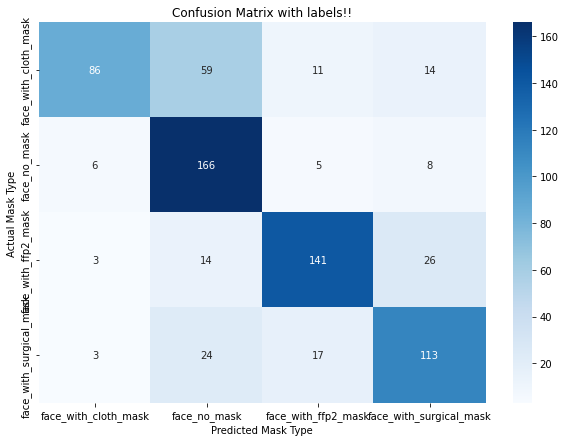

In [24]:
show_confusion_matrix(y_actuals, y_preds)

heat_map(y_actuals, y_preds, 'Predicted Mask Type', 'Actual Mask Type', 'Confusion Matrix with labels!!')

In [25]:
def split_test_set_by_category(dataset, class_index, group):
  """
  Returns two datasets from spliting, based on the binary category it belongs to (e.g. Female/Male).
  """
  label_0, label_1 = group.keys()
  
  test_0 = []
  test_1 = []
  for index, row in enumerate(dataset):
    if row[class_index] == label_0:
      test_0.append(index)
    elif row[class_index] == label_1:
      test_1.append(index)

  return test_0, test_1

def calculate_classification_metrics(y_actual, y_predicted, threshold):
  throshold_layer = lambda x: 1 if x >= threshold else 0
  
  y_predicted = np.array([throshold_layer(i) for i in y_predicted], dtype=np.float64)

  cf_matrix = confusion_matrix(y_actual, y_predicted).ravel()

  tn, fp, fn, tp = cf_matrix[0], cf_matrix[1], cf_matrix[2], cf_matrix[3]
  """ Positive rate: % classified as positive (% predicted with correct face mask type) """
  pr = (tp + fp) / (tn + fp + fn + tp)

  """ Negative rate: % classified as negative (% predicted to default) """
  nr = (tn + fn) / (tn + fp + fn + tp)

  """ True positive rate: % of all positive that were classified correctly with its face mask. """
  tpr = 0
  if (tp + fn) != 0:
    tpr = tp / (tp + fn)

  """ False positive rate: % of all negatives that we miss-classified with the face mask. """
  fpr = 0
  if (fp + tn) != 0:
    fpr = fp / (fp + tn)

  return tp, fp, pr, nr, tpr, fpr


def run_algorithmic_interventions(test_0, test_1):
  results_columns = ['IntervationName', 'Correct', 'threshold_0', 'threshold_1', 'TruePositive0', 'FalsePositive0',
                       'PositiveRate0', 'NegativeRate0', 'TruePositiveRate0', 'FalsePositiveRate0', 'TruePositive1',
                       'FalsePositive1', 'PositiveRate1', 'NegativeRate1', 'TruePositiveRate1', 'FalsePositiveRate1']
                       
  results_df = pd.DataFrame(columns=results_columns)

  thresholds = np.arange(0, 1.01, 0.02)

  for t0 in thresholds:
      for t1 in thresholds:

          results_group_0 = calculate_classification_metrics(test_0[0], test_0[1], t0)

          results_group_1 = calculate_classification_metrics(test_1[0], test_1[1], t1)

          tp0, fp0, pr0, nr0, tpr0, fpr0 = results_group_0
          tp1, fp1, pr1, nr1, tpr1, fpr1 = results_group_1

          bias_function = (tp0 + tp1) - (fp0 + fp1)

          """
          Intervention 1: no fairness constraint
          """
          results_df = results_df.append(
              pd.DataFrame(
                  columns=results_columns,
                  data=[('MaxProfit', bias_function, t0, t1) + results_group_0 + results_group_1]))

          """
          Intervention 2: uses same FICO (Fair credit score) threshold for all groups
          """
          if t0 == t1:
              results_df = results_df.append(pd.DataFrame(
                  columns=results_columns,
                  data=[('GroupUnawareness', bias_function, t0, t1) + results_group_0 + results_group_1]))

          """
          Intervention 3: picks for each group a threshold such that the fraction of group members wearing the different types of face masks is the same
          """
          if round(pr0, 2) == round(pr1, 2):
              results_df = results_df.append(pd.DataFrame(
                  columns=results_columns,
                  data=[('DemographicParity', bias_function, t0, t1) + results_group_0 + results_group_1]))

          """
          Intervention 4: picks a threshold for each group such that fraction of people with the correct labeled face mask group members is the same.
          """
          if round(tpr0, 2) == round(tpr1, 2):
              results_df = results_df.append(pd.DataFrame(
                  columns=results_columns,
                  data=[('EqualOpportunity', bias_function, t0, t1) + results_group_0 + results_group_1]))
              """
              Intervention 5: requires both the fraction of people with the correct labeled face mask and the fraction of people with the incorrect labeled face mask to be constant across groups.
              """
              if round(fpr0, 2) == round(fpr1, 2):
                  results_df = results_df.append(pd.DataFrame(
                      columns=results_columns,
                      data=[('EqualisedOdds', bias_function, t0, t1) + results_group_0 + results_group_1]))
            
  return results_df

In [26]:
# Bias measures by Gender
test_gender_female_indexes, test_gender_male_indexes = split_test_set_by_category(gtest_dataset, columns.index('gender'), genderGroup)

print(test_gender_female_indexes)
print(test_gender_male_indexes)

[0, 2, 5, 6, 7, 9, 12, 14, 16, 19, 20, 21, 24, 25, 27, 30, 31, 32, 34, 37, 40, 41, 42, 43, 45, 53, 54, 55, 57, 59, 60, 61, 62, 64, 65, 67, 74, 77, 78, 80, 81, 83, 84, 86, 87, 91, 94, 95, 98, 99, 100, 101, 102, 106, 109, 110, 112, 116, 117, 118, 119, 121, 122, 126, 127, 128, 129, 130, 132, 133, 134, 135, 136, 138, 139, 143, 144, 145, 148, 150, 151, 153, 154, 156, 158, 159, 160, 162, 163, 166, 174, 179, 180, 182, 183, 185, 186, 187, 190, 197, 198, 199, 200, 201, 204, 209, 210, 212, 215, 218, 220, 223, 224, 227, 232, 234, 236, 238, 241, 243, 245, 246, 249, 250, 252, 254, 255, 256, 257, 258, 260, 261, 262, 264, 266, 267, 269, 273, 274, 281, 287, 289, 291, 292, 293, 296, 297, 299, 305, 313, 316, 317, 319, 321, 324, 325, 326, 327, 328, 334, 336, 338, 342, 343, 345, 346, 348, 351, 352, 353, 354, 358, 360, 362, 365, 366, 370, 376, 377, 378, 379, 380, 381, 385, 386, 387, 388, 390, 392, 394, 395, 396, 400, 403, 405, 408, 409, 410, 412, 416, 417, 421, 422, 428, 429, 430, 432, 433, 436, 437, 438, 

In [27]:
y_gender_female_actuals = np.array([y_actuals[i] for i in test_gender_female_indexes], dtype=np.float64)
y_gender_female_predictions = np.array([y_preds[i] for i in test_gender_female_indexes], dtype=np.float64)

y_gender_male_actuals = np.array([y_actuals[i] for i in test_gender_male_indexes], dtype=np.float64)
y_gender_male_predictions = np.array([y_preds[i] for i in test_gender_male_indexes], dtype=np.float64)

              precision    recall  f1-score   support

         0.0       0.90      0.58      0.71       108
         1.0       0.59      0.87      0.71        77
         2.0       0.70      0.74      0.72        76
         3.0       0.69      0.67      0.68        85

    accuracy                           0.70       346
   macro avg       0.72      0.72      0.70       346
weighted avg       0.74      0.70      0.70       346



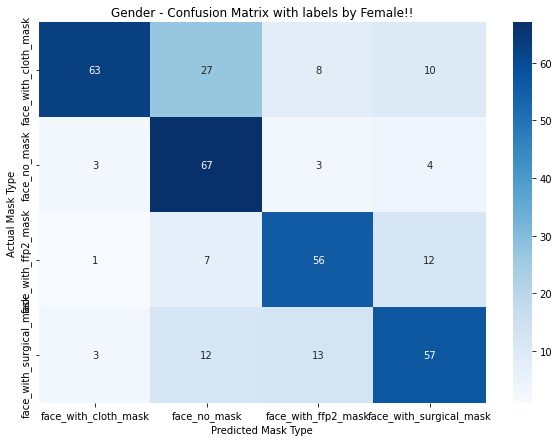

In [28]:
show_confusion_matrix(y_gender_female_actuals, y_gender_female_predictions)

heat_map(y_gender_female_actuals, y_gender_female_predictions, 'Predicted Mask Type', 'Actual Mask Type', 'Gender - Confusion Matrix with labels by Female!!')

              precision    recall  f1-score   support

         0.0       0.82      0.37      0.51        62
         1.0       0.66      0.92      0.77       108
         2.0       0.90      0.79      0.84       108
         3.0       0.72      0.78      0.75        72

    accuracy                           0.75       350
   macro avg       0.78      0.71      0.72       350
weighted avg       0.78      0.75      0.74       350



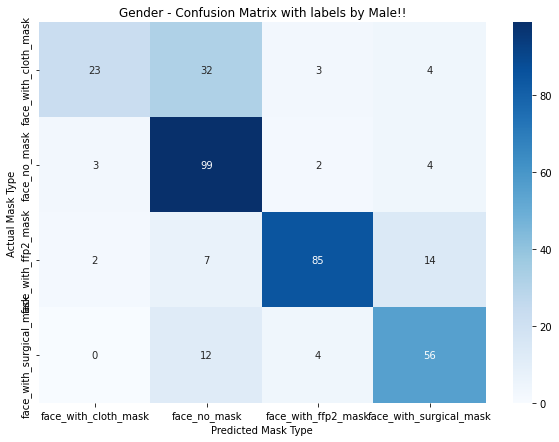

In [29]:
show_confusion_matrix(y_gender_male_actuals, y_gender_male_predictions)

heat_map(y_gender_male_actuals, y_gender_male_predictions, 'Predicted Mask Type', 'Actual Mask Type', 'Gender - Confusion Matrix with labels by Male!!')

In [30]:
gender_results = run_algorithmic_interventions(
    [y_gender_female_actuals, y_gender_female_predictions],
    [y_gender_male_actuals, y_gender_male_predictions]
)

gender_results.to_csv(os.path.join(root_folder, 'fairness_by_gender.csv'))

In [31]:
# Bias measures by Age
test_age_group_0_indexes, test_age_group_1_indexes = split_test_set_by_category(gtest_dataset, columns.index('age'), ageGroup)

print(test_age_group_0_indexes)
print(test_age_group_1_indexes)

[0, 1, 2, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 24, 26, 27, 28, 31, 32, 33, 34, 36, 37, 39, 42, 43, 45, 46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 64, 65, 66, 70, 71, 76, 77, 80, 82, 83, 84, 85, 86, 87, 88, 89, 94, 96, 97, 100, 101, 102, 103, 104, 105, 106, 107, 109, 110, 111, 113, 114, 115, 116, 117, 119, 121, 123, 124, 126, 127, 128, 129, 130, 131, 132, 135, 136, 137, 138, 139, 140, 141, 145, 146, 150, 151, 152, 153, 154, 156, 158, 159, 162, 163, 165, 166, 169, 170, 171, 173, 174, 178, 181, 183, 185, 190, 194, 195, 196, 197, 198, 199, 201, 202, 204, 205, 206, 207, 208, 209, 210, 211, 213, 214, 217, 218, 220, 221, 222, 223, 224, 225, 226, 227, 231, 233, 234, 235, 237, 238, 239, 240, 241, 242, 243, 245, 246, 248, 249, 251, 252, 253, 255, 256, 257, 258, 259, 260, 262, 263, 265, 268, 269, 272, 273, 275, 280, 282, 283, 286, 287, 289, 292, 293, 294, 295, 296, 298, 299, 303, 304, 305, 306, 307, 309, 310, 312, 313, 314, 315, 316, 317, 318, 319, 321, 322, 323, 324, 

In [32]:
y_age_group_0_actuals = np.array([y_actuals[i] for i in test_age_group_0_indexes], dtype=np.float64)
y_age_group_0_predictions = np.array([y_preds[i] for i in test_age_group_0_indexes], dtype=np.float64)

y_age_group_1_actuals = np.array([y_actuals[i] for i in test_age_group_1_indexes], dtype=np.float64)
y_age_group_1_predictions = np.array([y_preds[i] for i in test_age_group_1_indexes], dtype=np.float64)

              precision    recall  f1-score   support

         0.0       0.85      0.50      0.63       107
         1.0       0.65      0.89      0.76       123
         2.0       0.83      0.78      0.80       137
         3.0       0.67      0.73      0.70        96

    accuracy                           0.73       463
   macro avg       0.75      0.72      0.72       463
weighted avg       0.76      0.73      0.73       463



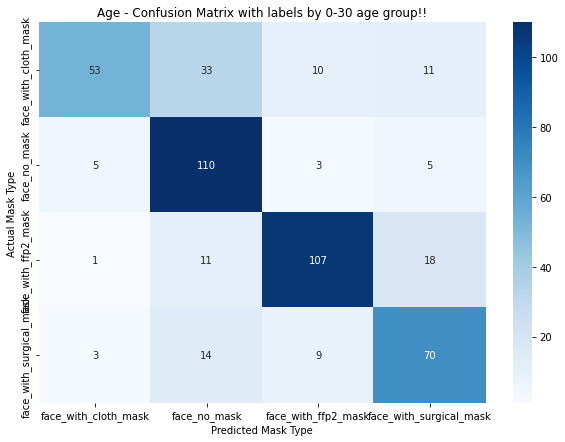

In [33]:
show_confusion_matrix(y_age_group_0_actuals, y_age_group_0_predictions)

heat_map(y_age_group_0_actuals, y_age_group_0_predictions, 'Predicted Mask Type', 'Actual Mask Type', 'Age - Confusion Matrix with labels by 0-30 age group!!')

              precision    recall  f1-score   support

         0.0       0.92      0.52      0.67        63
         1.0       0.59      0.90      0.71        62
         2.0       0.76      0.72      0.74        47
         3.0       0.75      0.70      0.73        61

    accuracy                           0.71       233
   macro avg       0.75      0.71      0.71       233
weighted avg       0.75      0.71      0.71       233



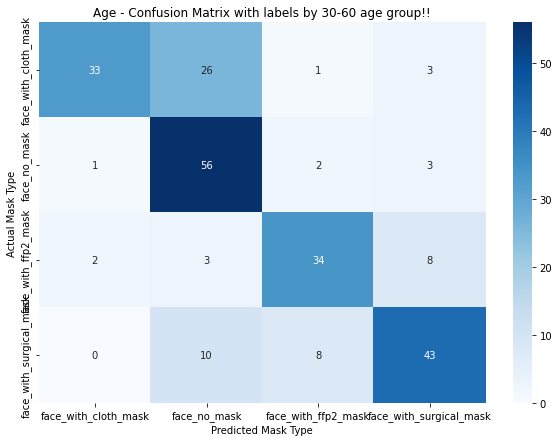

In [34]:
show_confusion_matrix(y_age_group_1_actuals, y_age_group_1_predictions)

heat_map(y_age_group_1_actuals, y_age_group_1_predictions, 'Predicted Mask Type', 'Actual Mask Type', 'Age - Confusion Matrix with labels by 30-60 age group!!')

In [35]:
age_results = run_algorithmic_interventions(
    [y_age_group_0_actuals, y_age_group_0_predictions],
    [y_age_group_1_actuals, y_age_group_1_predictions]
)

age_results.to_csv(os.path.join(root_folder, 'fairness_by_age.csv'))

In [36]:
gender_results_df = pd.read_csv(os.path.join(root_folder, 'fairness_by_gender.csv'), index_col=[0]).reset_index(drop=True).round(20)

max_profits_gender = gender_results_df.loc[gender_results_df.groupby(['IntervationName'])['Correct'].idxmax()]  
max_profits_gender = max_profits_gender.sort_values('Correct', ascending=False)

max_profits_gender

,IntervationName,Correct,threshold_0,threshold_1,TruePositive0,FalsePositive0,PositiveRate0,NegativeRate0,TruePositiveRate0,FalsePositiveRate0,TruePositive1,FalsePositive1,PositiveRate1,NegativeRate1,TruePositiveRate1,FalsePositiveRate1
109,EqualOpportunity,-84,0.02,0.02,0,45,0.416667,0.583333,0,0.416667,0,39,0.629032,0.370968,0,0.629032
108,GroupUnawareness,-84,0.02,0.02,0,45,0.416667,0.583333,0,0.416667,0,39,0.629032,0.370968,0,0.629032
107,MaxProfit,-84,0.02,0.02,0,45,0.416667,0.583333,0,0.416667,0,39,0.629032,0.370968,0,0.629032
2,DemographicParity,-170,0.00,0.00,0,108,1.000000,0.000000,0,1.000000,0,62,1.000000,0.000000,0,1.000000
4,EqualisedOdds,-170,0.00,0.00,0,108,1.000000,0.000000,0,1.000000,0,62,1.000000,0.000000,0,1.000000


In [37]:
max_profits_gender[['threshold_0', 'threshold_1']].describe().loc[['mean', 'std']]

,threshold_0,threshold_1
mean,0.012000,0.012000
std,0.010954,0.010954


In [38]:
age_group_results_df = pd.read_csv(os.path.join(root_folder, 'fairness_by_age.csv'), index_col=[0]).reset_index(drop=True).round(2)

max_profits_age_group = age_group_results_df.loc[age_group_results_df.groupby(['IntervationName'])['Correct'].idxmax()]  
max_profits_age_group = max_profits_age_group.sort_values('Correct', ascending=False)

max_profits_age_group

,IntervationName,Correct,threshold_0,threshold_1,TruePositive0,FalsePositive0,PositiveRate0,NegativeRate0,TruePositiveRate0,FalsePositiveRate0,TruePositive1,FalsePositive1,PositiveRate1,NegativeRate1,TruePositiveRate1,FalsePositiveRate1
109,EqualOpportunity,-84,0.02,0.02,0,54,0.5,0.5,0,0.5,0,30,0.48,0.52,0,0.48
108,GroupUnawareness,-84,0.02,0.02,0,54,0.5,0.5,0,0.5,0,30,0.48,0.52,0,0.48
107,MaxProfit,-84,0.02,0.02,0,54,0.5,0.5,0,0.5,0,30,0.48,0.52,0,0.48
2,DemographicParity,-170,0.00,0.00,0,107,1.0,0.0,0,1.0,0,63,1.00,0.00,0,1.00
4,EqualisedOdds,-170,0.00,0.00,0,107,1.0,0.0,0,1.0,0,63,1.00,0.00,0,1.00


In [39]:
max_profits_age_group[['threshold_0', 'threshold_1']].describe().loc[['mean', 'std']]

,threshold_0,threshold_1
mean,0.012000,0.012000
std,0.010954,0.010954


In [40]:
def show_image(image, title, xlabel, ylabel):
  plt.imshow(image)
  plt.title(to_face_mask_type_str(title))
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.show()

In [41]:
new_images_path = os.path.join(root_folder, "./test")

new_images = os.listdir(new_images_path)

with torch.no_grad():
    for image in new_images:
      file_name = image
      image = transform(Image.open(os.path.join(new_images_path, image)).convert('RGB'))
      old_image = image
      image = image.unsqueeze(0)
      image = image.to(device)
      labels = model(image)
      _, predicted = torch.max(labels.data, 1)
      show_image(old_image, to_face_mask_type_str(predicted.to('cpu')), )


TypeError: ignored

In [ ]:
cp = 0
for image, label, _, _ in gtest_dataset:
  image = transforms.ToPILImage()(image)
  cp+=1
  if cp >= 10:
    break

In [ ]:
# transform = transforms.Compose(
#     [transforms.Resize((100, 100)),
#         transforms.ToTensor(),
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# new_data_folder = "./data/new/images"

# tensor_image = transforms.ToPILImage()(transform(Image.open(os.path.join(new_data_folder, '1.png'))))

# import matplotlib.pyplot as plt

# plt.imshow(tensor_image)
# plt.show()